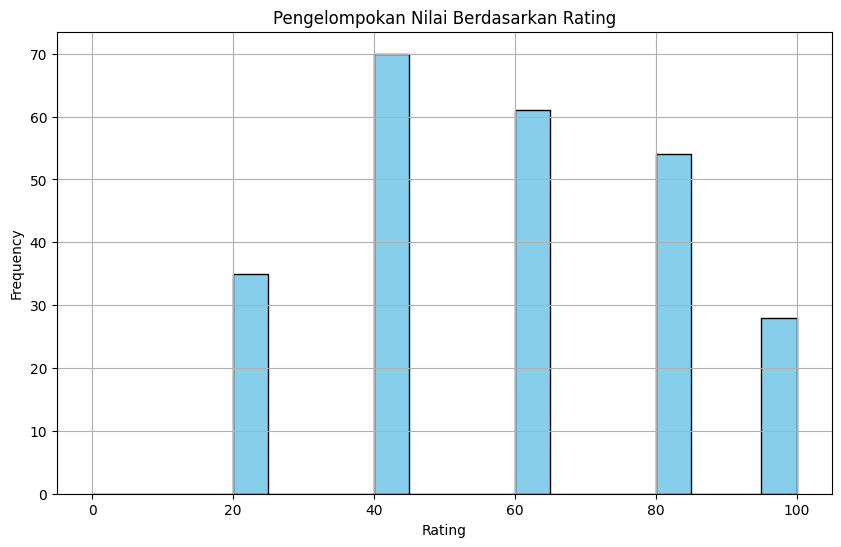

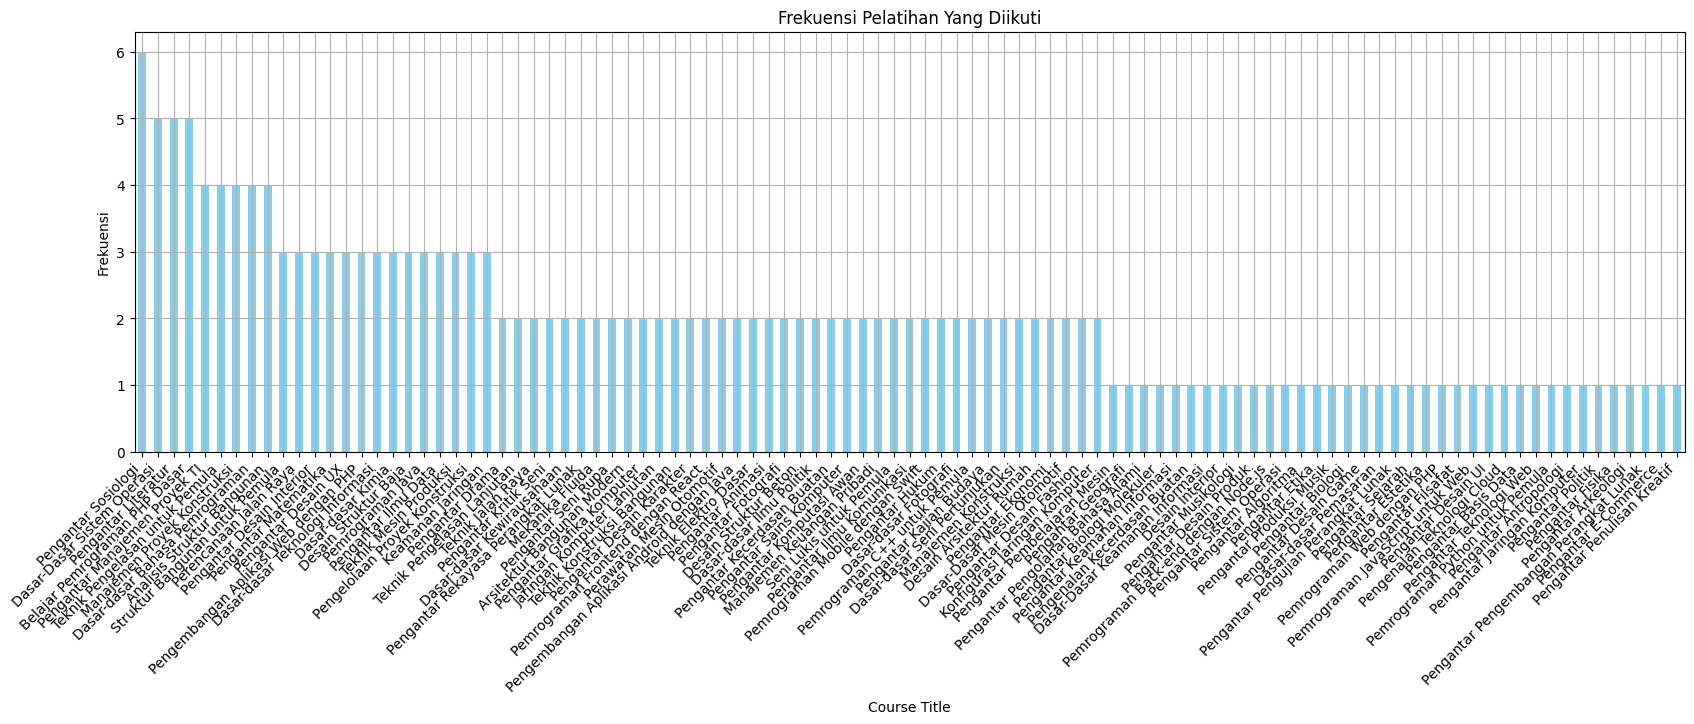

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Pandas Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

# Load data CBF dari CSV
cbf = pd.read_csv('cbf.csv')

# Data Preprocessing untuk CBF
def combine_text(row):
    return ' '.join(row.values.astype(str))

cbf['all_text'] = cbf.apply(combine_text, axis=1)

# Vektorisasi TF-IDF untuk CBF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_cbf = tfidf_vectorizer.fit_transform(cbf['all_text'])
cosine_sim_cbf = cosine_similarity(tfidf_matrix_cbf, tfidf_matrix_cbf)

# Fungsi Rekomendasi untuk CBF
def recommend_CBF(course_title, top_n=5):
    if course_title not in cbf['course_title'].values:
        return pd.DataFrame(columns=['course_id', 'course_title', 'category_type'])
    
    course_index = cbf[cbf['course_title'] == course_title].index[0]
    similarity_scores = pd.DataFrame(cosine_sim_cbf[course_index], columns=["score"])
    course_indices = similarity_scores.sort_values("score", ascending=False)[1:top_n+1].index
    
    recommended_courses = cbf.iloc[course_indices].drop_duplicates(subset=['course_id']).reset_index(drop=True)
    return recommended_courses[['course_id', 'course_title', 'category_type']]

# Visualisasi Distribusi Rating
def visualize_ratings_distribution():
    plt.figure(figsize=(10, 6))
    plt.hist(cbf['rating'], bins=20, range=(0, 100), color='skyblue', edgecolor='black')
    plt.title('Pengelompokan Nilai Berdasarkan Rating')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

visualize_ratings_distribution()

# Visualisasi Frekuensi Pelatihan yang Diikuti
def visualize_course_title_distribution(output_dir):
    plt.figure(figsize=(20, 12))
    cbf['course_title'].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Frekuensi Pelatihan Yang Diikuti')
    plt.xlabel('Course Title')
    plt.ylabel('Frekuensi')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()

    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "course_title_distribution.png")
    plt.savefig(output_file)
    plt.show()

    # print(f"Plot saved to {output_file}")

    visualize_course_title_distribution(output_dir)

# Fungsi Evaluasi Mean Average Precision (MAP)
def precision(recommendations, actual):
    tp = len(set(recommendations) & set(actual))
    return tp / len(recommendations) if len(recommendations) > 0 else 0

def evaluate_map(test_data, k=5):
    map_cf, map_cbf, map_hybrid = [], [], []
    for user in test_data['user_id'].unique():
        actual = test_data[test_data['user_id'] == user]['course_id']
        cf_recs = recommend_CBF('Create Rest API', k)
        cbf_recs = recommend_CBF('Create Rest API', k)
        hybrid_recs = list(set(cf_recs['course_id']).union(set(cbf_recs['course_id'])))

        map_cf.append(precision(cf_recs['course_id'], actual))
        map_cbf.append(precision(cbf_recs['course_id'], actual))
        map_hybrid.append(precision(hybrid_recs, actual))

    return np.mean(map_cf), np.mean(map_cbf), np.mean(map_hybrid)

# Split data menjadi train dan test set
train_data, test_data = train_test_split(cbf, test_size=0.2, random_state=42)

# Evaluasi MAP sebelum dan sesudah pengujian
map_cf_before, map_cbf_before, map_hybrid_before = evaluate_map(test_data)
cbf = train_data
map_cf_after, map_cbf_after, map_hybrid_after = evaluate_map(test_data)

# Visualisasi Hasil Evaluasi
labels = ['Collaborative Filtering (CF)', 'Content-Based Filtering (CBF)', 'Hybrid']
before_scores = [map_cf_before, map_cbf_before, map_hybrid_before]
after_scores = [map_cf_after, map_cbf_after, map_hybrid_after]

x = np.arange(len(labels))
width = 0.35

# Visualizing the frequency distribution of categorical variables
plt.figure(figsize=(20, 12))  # Sesuaikan ukuran figure sesuai kebutuhan

# Frequency distribution of course organizations
plt.subplot(2, 1, 1)
cbf['course_title'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Frekuensi Pelatihan Yang Diikuti')
plt.xlabel('Course Title')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45, ha='right')  # ha='right' untuk merotasi dan mensejajarkan label ke kanan
plt.grid(True)

plt.tight_layout()  # Sesuaikan tata letak agar tidak tumpang tindih
